# A* Algo

In [760]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math

n = 5
p=0.3
matrix = []
block_unblock_matrix = []
agent_matrix = []
parentDict = {}

In [761]:
def euclidean_distance_calc(i, j, n):
    return math.sqrt(((n - i)**2 + (n - j)**2))

def chebyshev_distance_calc(i, j, n):
    return max((n - i), (n - j))


def manhattan_distance_calc(i, j, n):
    return abs(n - i) + abs(n - j)

def compute_hofn(n, heuristic):
    
    hofn_matrix = []
    for i in range(n):
        hofn_row = []
        for j in range(n):
            if heuristic == "euclidean":
                dist = euclidean_distance_calc(i, j, n -1)
            elif heuristic == "chebyshev":
                dist = chebyshev_distance_calc(i, j, n -1)
            elif heuristic == "manhattan":
                dist = manhattan_distance_calc(i, j, n -1)
            hofn_row.append(dist)
        hofn_matrix.append(hofn_row)
    return np.array(hofn_matrix)

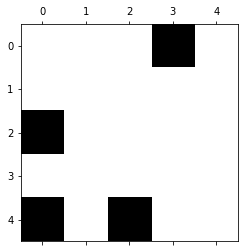

In [762]:
def populateMatrix(n,p):
    global block_unblock_matrix
    np_array = np.random.rand(n*n)
    block = lambda x: 0 if x>=p else 1
    vectorized_block = np.vectorize(block)
    np_array = vectorized_block(np_array).reshape(n,n)
    np_array[0,0]=0
    np_array[n-1,n-1] =0
    block_unblock_matrix = np.asmatrix(np_array)

#############testing on hard coded matrix ###########
# block_unblock_matrix = [[0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0],
#         [0, 1, 0, 0, 0],
#         [1, 0, 0, 1, 0]]
#######################################
populateMatrix(n,p)
# block_unblock_matrix = np.matrix(block_unblock_matrix)
plt.spy(block_unblock_matrix)

In [763]:
def initialize(dim,p):
    n = dim
    block_unblock_matrix = []
    agent_matrix = []
    parentDict = {}
    populateMatrix(n,p)

In [764]:
block_unblock_matrix

matrix([[0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0]])

g(n) matrix

In [765]:
def compute_gofn(n):
    k = 0
    gofn = []
    one_row = []
    for j in range(n):
        one_row.append(k)
        k += 1
    gofn.append(one_row)
    for i in range(n-1):
        one_row = [x+1 for x in one_row]
        gofn.append(one_row)

    gofn_matrix = np.array([np.array(xi) for xi in gofn])
    return gofn_matrix

In [766]:
def get_gofn(gofn_matrix, row, col):
    return gofn_matrix[row][col]

In [767]:
def get_hofn(hofn_matrix, row, col):
    return hofn_matrix[row][col]

In [768]:
def get_children(matrix, x, y, n, gofn, visited_list):
    allChildren = [(x+1,y,gofn+1),#down
                   (x-1,y,gofn+1),#up
                   (x,y+1,gofn+1),#right
                   (x,y-1,gofn+1)]#left
    if x+1 > n-1:
        allChildren.remove((x+1,y,gofn+1))
    if x-1 < 0:
        allChildren.remove((x-1,y,gofn+1))
    if y+1 > n-1:
        allChildren.remove((x,y+1,gofn+1))
    if y-1 < 0:
        allChildren.remove((x,y-1,gofn+1))
    allChildren = [node for node in allChildren if node[:2] not in visited_list]
    
    return allChildren

In [769]:
def sort(open_list, gofn_matrix, hofn_matrix):
    sort_dict = {}
    for node in open_list:
        row = node[0]
        col = node[1]
        gofn = gofn_matrix.item(row,col)
        hofn = hofn_matrix.item(row,col)
#         print("node", node, " - gofn: ", gofn,  " - hofn: ", hofn)
        sort_dict[node] = hofn
        
        sort_dict = dict(sorted(sort_dict.items(), key=lambda item: item[1]))
    return sort_dict

In [770]:
def display(trajectory_path):
    np_array = np.zeros((n,n), dtype=int)
#     np_array = populateMatrix(n,0)
    final_display_matrix = np.asmatrix(np_array)
    for path in trajectory_path:
        final_display_matrix[path[:2]] = 1
    colormap = colors.ListedColormap(["white","green"])
    plt.imshow(final_display_matrix, cmap=colormap)
    plt.show()

In [771]:
def display2(trajectory_path,matrix):
   
    temp = matrix.copy()
    for path in trajectory_path:
        temp[path[:2]] = 2
    colormap = colors.ListedColormap(["white","black","green"])
    plt.imshow(temp, cmap=colormap)
    plt.show()

In [772]:
def node_block_check(children_dict, block_unblock_matrix, current_node):
    node_blocked = 0
    node_removal_list = []
#     for node in children_dict:
    children_node_list = children_dict[current_node].copy()
    for i in range(len(children_node_list)):
        #checking if all children are blocked
        if block_unblock_matrix.item(children_node_list[i]) == 1:
            node_blocked += 1
            children_dict[current_node].remove(children_node_list[i])
        if node_blocked == len(children_node_list):
            node_removal_list.append(current_node)
    return node_removal_list

In [773]:
def buildParentDict(children_dict):
    global parentDict
    for key in children_dict.keys():
        for child in children_dict[key]:
            parentDict[child] = key

In [774]:
def getShortestPath(start):
    path = [(n-1,n-1)]
    node = (n-1,n-1)
    start = start[:2]
    while node != start:
        path.append(parentDict[node])
        node = parentDict[node]
    return path

In [775]:
def astar(start, agent_matrix):
    visited_list = []
    open_list = []
    trajectory_path = []
    trajectory_plus_gofn = []
    path_block = 0
    children_dict = {}
    i = 0
    goal = (n-1, n-1)
    num_of_cells_processed = 0

    open_list.append(start)
    gofn_matrix = compute_gofn(n)
    hofn_matrix = compute_hofn(n, "manhattan")

    while open_list:
        child_list = []
        current_node = open_list.pop(0)
        num_of_cells_processed += 1
        if current_node[:2] not in visited_list:
            visited_list.append(current_node[:2])
            if current_node[:2] not in trajectory_path: 
                trajectory_path.append(current_node[:2])
                trajectory_plus_gofn.append(current_node)

            if agent_matrix.item(current_node[0], current_node[1]) == 0:
                if current_node[0] == n-1 and current_node[1] == n-1:
#                     print("Reached Goal!!!!!!!!!!!!!!!!!!!!!!!")
                    trajectory_plus_gofn.append(current_node)
                    buildParentDict(children_dict)
                    shortestPath = getShortestPath(start)
                    return (trajectory_path,trajectory_plus_gofn,num_of_cells_processed,shortestPath)

                children = get_children(agent_matrix, current_node[0], current_node[1], n, current_node[2], visited_list)

                for x in children:
                    child_list.append(x[:2])
                children_dict[current_node[:2]] = child_list
                
                for node in children:
                    if node not in open_list:
                        open_list.append(node)
                sort_dict = sort(open_list, gofn_matrix, hofn_matrix)
                open_list = list(sort_dict.keys())
                node_removal_list = node_block_check(children_dict, agent_matrix, current_node[:2])
                for node in node_removal_list:
                    if node in trajectory_path:
                        trajectory_path.remove(node)
                        trajectory_plus_gofn = [i for i in trajectory_plus_gofn if i[:2] != node]

            else:
                if open_list == []:
                    print("There is no path available to goal Node**")
                    return ([],[], 0,[])
                else:
                    if current_node[:2] in trajectory_path:
                        trajectory_path.remove(current_node[:2])
                        trajectory_plus_gofn.remove(current_node)
        else:
            if open_list == []:
                    print("There is no path available to goal Node++")
                    return ([],[], 0,[])

In [776]:
def repeated_astar():
    global agent_matrix
    
    agent_matrix = np_array = populateMatrix(n,0)
    agent_matrix = np.asmatrix(np_array)
    goal_reached = False
    goal = (n-1,n-1)
    path = []
    final_path = [(0,0,0)]
    trajectory_length = 0
    num_of_cells =0
    
    while not goal_reached:
        (path1,path2,astar_num_cells,shortest_path) = astar(final_path[-1],agent_matrix)
        num_of_cells += astar_num_cells
        if(path1 == []):
            break
        
        for node in path2:
            if block_unblock_matrix[node[:2]] == 0:
                if node not in final_path:
                    final_path.append(node)
                    trajectory_length += 1
                    if node[:2] == goal:
                        goal_reached = True
                        break
            else:
                agent_matrix[node[:2]] = 1
                trajectory_length += 2
                break

    return (trajectory_length, num_of_cells)

A*: 
trajectory A*:  [(0, 0), (1, 0), (1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (4, 3), (4, 4)]


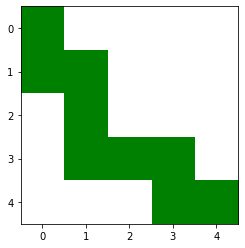

shortest path A*:  [(4, 4), (4, 3), (3, 3), (3, 2), (3, 1), (2, 1), (1, 1), (1, 0), (0, 0)]


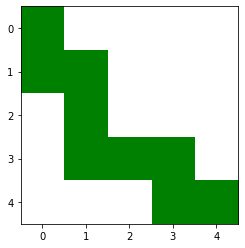

In [777]:
######## Repeated A* #####################
# repeated_astar()
########## A* on full gridworld ###########
print("A*: ")
(trajectory_path,_,_,shortest_path) = astar((0,0,0),block_unblock_matrix)
print("trajectory A*: ",trajectory_path)
display(trajectory_path)
print("shortest path A*: ",shortest_path)
display(shortest_path)
#############################################
# parentDict = {}
############ A* on final discovered Gridworld ##########
# print("A* on final discovered gridworld:")
# trajectory_path ,_,_,shortest_path= astar((0,0,0),agent_matrix)
# print("trajectory_path for A* on final discovered world: ",trajectory_path)
# display2(trajectory_path,agent_matrix)
# print("shortest path for A* on final discovered world:")
# display2(shortest_path,agent_matrix)
# print("shortest path: ",shortest_path)

In [757]:
# block_unblock_matrix[block_unblock_matrix==0] = 1

############## Testing for range of values n=101 ###############

In [ ]:
# def check_threshold(num_of_runs,dimension,p_low,p_high,step):
#     probabilities = np.arange(p_low, p_high, step)
#     for prob in list(probabilities)
#         for i in range(num_of_runs):
#             initialize(dimension,prob)
#             (trajectory_path,_,_,shortest_path) = astar((0,0,0),block_unblock_matrix)
            
            
# # (trajectory_path,_,_,shortest_path) = astar((0,0,0),block_unblock_matrix)
# # print("trajectory A*: ",trajectory_path)
# # display(trajectory_path)
# # print("shortest path A*: ",shortest_path)
# # display(shortest_path)